__R-Model__ is the model that takes `r-neighborhood availability` into consideration of future movement decision.

For such simple lattice model, each agent has __at most__ two possible directions to proceed to their destinations: right and vertical (either up or down). Built on top of the assumption that agents do __NOT__ move back (left in this case), __R-Model__ strengthens eacha agent with the ability to know which cell(s) is available so that they can move in this timestep with higher chances.

Decreasing probability: $\frac{1}{(d+1)^{2.2}}$

09-04-2017

<hr>

In [1]:
import warnings
from itertools import product

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock

In [3]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import BaseScheduler

In [4]:
from mesa.datacollection import DataCollector

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def countAgentsOnBoard(model):
    '''Count the # of agents on a board'''
    return sum([not model.grid.is_cell_empty(cell[1:]) \
                for cell in model.grid.coord_iter()])

In [8]:
def repulsiveProbability(d, k=2.2):
    return 1./((d+1)**k)

<hr>

In [67]:
class MyActivation(BaseScheduler):
    ''' A customized activation scheduler to move agents simultaneously and break ties randomly. '''

    def break_ties(self):
        ''' Break ties randomly'''
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.find_newPos()
            
        agent_pos_df = pd.DataFrame([(agent, agent.newPos) for agent in self.agents[:] if agent.exitday is None],
                                    columns=['agent', 'newPos'])
        for newPos, df in agent_pos_df.groupby('newPos'):
            ''' randomly select one agent to move the that `newPos`'''
            selected_agent = df.agent[np.random.choice(df.agent.index)]
            for agent in df.agent:
                if agent is selected_agent:
                    continue
                ## agents not selected will stay put
                ## by setting `newPos` to `None`.
                agent.newPos = None
            print(newPos, [item.unique_id for item in df.agent], selected_agent.unique_id, 
                  [(item.unique_id, item.pos, item.newPos) for item in df.agent if item != selected_agent])
    
    def check_availability(self):
        '''Check if agents' `newPos` are available'''
        for agent in self.agents[:]:
            if agent.newPos is None:
                continue
            ## for those who are going to move, check if their future `dest` is available
            newPos_content_list = agent.model.grid.get_cell_list_contents(agent.newPos)
            for newPos_content in newPos_content_list:
                if newPos_content.newPos is None:
                    ## if it cannot move, reset `newPos`
                    agent.newPos = None
                    break
            print(agent.unique_id, agent.pos, agent.newPos, 
                  [(a.unique_id, a.pos, a.newPos) for a in newPos_content_list])

    def check_avail_wrapper(self):
        '''Due to the problem of synchronization, repeat doing this until converges'''
        converge = False
        last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
        while not converge:
            self.check_availability()
            this_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            if np.array_equal(this_newPos_array, last_newPos_array):
                converge = True
            last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            
    def step(self):
        self.break_ties()
        self.check_avail_wrapper()
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.step()

<hr>

#### Agent and model class

##### Agents now know `r-neighborhood availability`

In [97]:
class CheckerAgent(Agent):
    '''
        A checker on the board showing on the left-most column
        and trying to go to the right-most column.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        model: the board that an agent will be in
        dest: destination
        birthday: the timestamp when an agent shows up in the left-most column
        exitday: the timestamp when an agent arrives at its `dest`
        R : `r-neighborhood availability`
    '''
    def __init__(self, aid, model, dest, birthday):
        super().__init__(aid, model)
        self.dest = dest
        self.newPos = None
        self.birthday = birthday
        self.exitday = None
        self.R = self.model.R

    def find_newPos(self):
        print('--Find-newPos--')
        current_dist = cityblock(self.pos, self.dest)
        possible_move_positions = list()
        radius = np.max((1, self.R))
        for neighbor in self.model.grid.iter_neighborhood(pos=self.pos, 
                                                          moore=False,
                                                          radius=radius):
            ## distance between the neighbor and its destination
            _dist = cityblock(neighbor, self.dest)
            if _dist < current_dist:
                #possible_move_positions.append((neighbor, 
                #                                self.model.grid.is_cell_empty(neighbor)))
                possible_move_positions.append(neighbor)
                
        ## `possible_move_positions` contain further-away cells (dist > 1)
        ## `r_neighborhood` would be those more than 1-hop away from `self.pos`
        r_neighborhood = [cell for cell in possible_move_positions if cityblock(cell, self.pos) > 1]
        ## `possible_move_positions` updated as those distances == 1 with `self.pos`
        possible_move_positions = [cell for cell in possible_move_positions if cell not in r_neighborhood]
        ## if more than two possible directions, raise Exception
        if len(possible_move_positions) > 2:
            print(possible_move_positions, r_neighborhood)
            raise Exception('More than two possible `newPos`\'s')
        ## if no possible directions, raise Exception
        elif len(possible_move_positions) < 1:
            raise Exception('Should have been removed!')
        
        ## only 1 possible choice, choose it
        if len(possible_move_positions) < 2:
            self.newPos  = possible_move_positions[0]
            return
        
        ## if there are two
        newPosProbability = (np.ones(shape=(len(possible_move_positions),), dtype=float)/len(possible_move_positions)).tolist()
        ## with no knowledge of the neighborhood, randomly choose one with equal probability
        ## else, check neighborhood availability
        if self.R > 0:
            for index in np.arange(len(possible_move_positions)):
                newPos = possible_move_positions[:][index]
                
                ## `r-1` neighborhood 
                newPos_neighbor = [cell for cell in r_neighborhood if cityblock(cell, newPos) <= self.R-1] 
                newPos_neighbor += [newPos]
                
                ## not empty, decrease probability
                newPosProbability[index] -= sum([repulsiveProbability(cityblock(self.pos, cell)) \
                                                 if not self.model.grid.is_cell_empty(cell) else 0 \
                                                 for cell in newPos_neighbor ])
        ## normalize probability 
        newPosProbability = np.asarray(newPosProbability)/float(np.sum(newPosProbability))
        self.newPos = possible_move_positions[np.random.choice(len(possible_move_positions), 
                                                               p=newPosProbability)]

        print(self.unique_id, self.pos, possible_move_positions, newPosProbability)    
        print('--Done-find-newPos--')
        
    def step(self):
        if self.newPos is not None:
            self.model.grid.move_agent(self, self.newPos)
        if self.pos == self.dest:
            ## upon arrival, remove itself from the grid
            self.model.grid.remove_agent(self)
            #self.model.schedule.remove(self)
            self.exitday = self.model.timestamp
            print('Agent %d exits at time %d'%(self.unique_id, self.exitday))

##### Board model modified

Add `DataCollector` to the model.

In [98]:
class CheckerBoardModel(Model):
    '''
        A checker board bearing the agents.
        Each time step, a constant of agents will be added to the left-most column if avaialble.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        numAgents : the number of agents generated at each timestamp
        boardSize : the width and height of the grid
        R : `R-neighborhood availability`
        schedule : the scheduler to use
        timestamp : the current timestamp (starts at 0)
    '''
    def __init__(self, numAgents, boardSize, R=0, seed=None):
        super().__init__(seed)
        ## number of agents
        if numAgents > boardSize:
            warnings.warn("# of agents is larger than the board size! Use board size %d as the number of agents"%boardSize,
                           RuntimeWarning)
            numAgents = boardSize
        self.numAgents = np.min((numAgents, boardSize))
        self.R = R
        ## Not toroidial: cannot go across the border.
        self.grid = MultiGrid(boardSize, boardSize, False)
        self.schedule = MyActivation(self)
        self.timestamp = 0
        #self.cellCoords = list(product(np.arange(self.grid.width), 
        #                                np.arange(self.grid.width)))
        self.datacollector = DataCollector(
                                           model_reporters={"agentsOnBoard": countAgentsOnBoard},
                                           agent_reporters={'birthday': lambda a: a.birthday,
                                                            'exitday': lambda a: a.exitday}
                                          )
        #print('Current timestamp %d'%self.timestamp)
        ## Create agents
        for i in np.arange(self.numAgents):
            a = CheckerAgent(aid=i+1,
                             model=self,
                             birthday = self.timestamp,
                             dest=(boardSize-1,
                                   np.random.choice(self.grid.width)))
            ## destinations are sampled on the right-most column
            self.schedule.add(a)
            ## place they on the left-most column
            while True:
                xi = np.random.choice(self.grid.width)
                if self.grid.is_cell_empty((0, xi)):
                    self.grid.place_agent(a, (0, xi))
                    a.newPos = (0, xi)
                    break
                else:
                    continue
            
    def generate_new_agents(self):
        '''Generate new agents to the board if avaialble, AFTER step function'''
        ## check left-most columns availability
        available_cells = [xi for xi in np.arange(self.grid.width) \
                           if self.grid.is_cell_empty((0, xi))]
        numNewAgents = np.min((len(available_cells), self.numAgents))
        ## if no available slots, do not generate new agents
        if numNewAgents < 1:
            return
        ## re-order the availabilities randomly
        random_indices = np.random.choice(range(len(available_cells)), 
                                          replace=False, 
                                          size=numNewAgents)
        available_cells = [available_cells[i] for i in random_indices]
                                                                        
        ## index of the emerging agents: current max + 1
        starting_idx = max([a.unique_id for a in self.schedule.agents[:]]) + 1
        ## randomly assign positions (for k agents, k is the min of board size and availability)
        for i in np.arange(len(available_cells)):
            a = CheckerAgent(aid=starting_idx+i,
                             model=self,
                             birthday=self.timestamp,
                             dest=(self.grid.width-1,
                                   np.random.choice(self.grid.width)))
            self.schedule.add(a)
            self.grid.place_agent(a, (0, available_cells[i]))
            
    def check_cell_content(self):
        '''Check if one cell contains more than one agent at one timestamp after `step` and `generate` is done.'''
        cell_agent_count = dict()
        for cell in self.grid.coord_iter():
            cell_agent_count[cell[1:]] = len(cell[0])
        violated_cells = [cell for cell in cell_agent_count 
                          if cell_agent_count[cell] > 1]
        if len(violated_cells) > 0:
            print(violated_cells)
            raise Exception('More than two agents on one cell')
                
        
    def step(self):
        '''Advance the model by one step.
        
            One step includes:
            1) Move existing nodes using scheduler
            2) Generate new agents
            3) increment timestamp
        '''
        self.datacollector.collect(self)
        self.schedule.step()
        self.generate_new_agents()
        self.timestamp += 1
        self.check_cell_content()
        print('Current timestamp %d'%self.timestamp)
        print('-----------------------------------')

#### Testing code

In [107]:
boardModel = CheckerBoardModel(2, 3, 2, seed=np.random.randint(100))

##### Try to move the agents

In [108]:
for i in range(100):
    boardModel.step()

--Find-newPos--
1 (0, 2) [(0, 1), (1, 2)] [ 0.36090995  0.63909005]
--Done-find-newPos--
--Find-newPos--
2 (0, 1) [(1, 1), (0, 2)] [ 0.63909005  0.36090995]
--Done-find-newPos--
(0, 1) [1] 1 []
(1, 1) [2] 2 []
1 (0, 2) (0, 1) [(2, (0, 1), (1, 1))]
2 (0, 1) (1, 1) []
Current timestamp 1
-----------------------------------
--Find-newPos--
--Find-newPos--
2 (1, 1) [(2, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
3 (0, 0) [(1, 0), (0, 1)] [ 0.72132497  0.27867503]
--Done-find-newPos--
--Find-newPos--
(1, 0) [3] 3 []
(1, 1) [1] 1 []
(1, 2) [4] 4 []
(2, 1) [2] 2 []
1 (0, 1) (1, 1) [(2, (1, 1), (2, 1))]
2 (1, 1) (2, 1) []
3 (0, 0) (1, 0) []
4 (0, 2) (1, 2) []
Current timestamp 2
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
3 (1, 0) [(2, 0), (1, 1)] [ 0.72132497  0.27867503]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
(1, 1) [6] 6 []
(1, 2) [5] 5 []
(2, 0) [3] 3 []
(2, 1) [1] 1 []
(2, 2) [2, 4] 4 [(2, (2, 1), None

14 None (2, 2) []
15 None (2, 2) []
21 None (2, 2) []
25 (1, 0) None [(23, (2, 0), None)]
26 (0, 1) (1, 1) [(28, (1, 1), (2, 1))]
27 None (2, 2) []
28 (1, 1) None [(22, (2, 1), None)]
29 None (2, 2) []
30 (0, 0) None [(25, (1, 0), None)]
31 (1, 2) (2, 2) []
32 (0, 2) (1, 2) [(31, (1, 2), (2, 2))]
2 None (2, 2) []
3 None (2, 2) []
4 None (2, 2) []
5 None (2, 2) []
7 None (2, 2) []
11 None (2, 2) []
12 None (2, 2) []
14 None (2, 2) []
15 None (2, 2) []
21 None (2, 2) []
26 (0, 1) None [(28, (1, 1), None)]
27 None (2, 2) []
29 None (2, 2) []
31 (1, 2) (2, 2) []
32 (0, 2) (1, 2) [(31, (1, 2), (2, 2))]
2 None (2, 2) []
3 None (2, 2) []
4 None (2, 2) []
5 None (2, 2) []
7 None (2, 2) []
11 None (2, 2) []
12 None (2, 2) []
14 None (2, 2) []
15 None (2, 2) []
21 None (2, 2) []
27 None (2, 2) []
29 None (2, 2) []
31 (1, 2) (2, 2) []
32 (0, 2) (1, 2) [(31, (1, 2), (2, 2))]
Current timestamp 23
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--F

41 (2, 0) (2, 1) []
42 (1, 0) (2, 0) [(41, (2, 0), (2, 1))]
43 None (2, 1) []
44 None (2, 2) []
45 (0, 0) (1, 0) [(42, (1, 0), (2, 0))]
46 (1, 2) (2, 2) []
47 (0, 1) (1, 1) []
48 (0, 2) (0, 1) [(47, (0, 1), (1, 1))]
Agent 41 exits at time 37
Agent 42 exits at time 37
Agent 46 exits at time 37
Current timestamp 38
-----------------------------------
--Find-newPos--
--Find-newPos--
47 (1, 1) [(1, 0), (2, 1)] [ 0.36090995  0.63909005]
--Done-find-newPos--
--Find-newPos--
48 (0, 1) [(0, 0), (1, 1)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
50 (0, 0) [(1, 0), (0, 1)] [ 0.59378302  0.40621698]
--Done-find-newPos--
(0, 1) [50] 50 []
(1, 1) [48] 48 []
(1, 2) [49] 49 []
(2, 0) [45] 45 []
(2, 1) [47] 47 []
26 None (2, 1) []
28 None (2, 1) []
30 None (2, 1) []
31 None (2, 1) []
33 None (2, 1) []
35 None (2, 1) []
36 None (2, 1) []
38 None (2, 2) []
39 None (2, 1) []
40 None (2, 1) []
41 None (2, 1) []
42 None (2, 0) []
43 None (2, 1) []
44 None (2, 2) []
45 (1, 0) (2, 0) []

66 (0, 2) None [(65, (0, 1), None)]
67 (1, 0) None [(64, (2, 0), None)]
42 None None [(64, (2, 0), None)]
45 None None [(64, (2, 0), None)]
47 None None [(64, (2, 0), None)]
48 None None [(64, (2, 0), None)]
51 None None [(64, (2, 0), None)]
56 None None [(64, (2, 0), None)]
57 None None [(64, (2, 0), None)]
59 None None [(64, (2, 0), None)]
Current timestamp 52
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
66 (0, 2) [(0, 1), (1, 2)] [ 0.59378302  0.40621698]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
68 (0, 0) [(1, 0), (0, 1)] [ 0.5  0.5]
--Done-find-newPos--
(1, 0) [68] 68 []
(1, 1) [65] 65 []
(1, 2) [66] 66 []
(2, 0) [67] 67 []
(2, 1) [60, 62, 64] 62 [(60, (2, 2), None), (64, (2, 0), None)]
(2, 2) [61, 63] 63 [(61, (2, 1), None)]
62 (1, 1) None [(61, (2, 1), None)]
63 (1, 2) None [(60, (2, 2), None)]
65 (0, 1) None [(62, (1, 1), None)]
66 (0, 2) None [(63, (1, 2), None)]
6

80 (0, 1) (1, 1) []
Agent 76 exits at time 70
Agent 78 exits at time 70
Current timestamp 71
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
81 (0, 2) [(0, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
82 (0, 1) [(1, 1), (0, 2)] [ 0.5  0.5]
--Done-find-newPos--
(0, 2) [82] 82 []
(1, 2) [81] 81 []
(2, 0) [75] 75 []
(2, 1) [80] 80 []
(2, 2) [79] 79 []
62 None (2, 1) []
64 None (2, 1) []
65 None (2, 1) []
66 None (2, 1) []
68 None (2, 2) []
69 None (2, 2) []
70 None (2, 2) []
71 None (2, 1) []
72 None (2, 2) []
73 None (2, 1) []
74 None (2, 1) []
75 (1, 0) (2, 0) []
76 None (2, 1) []
77 None (2, 2) []
78 None (2, 0) []
79 (1, 2) (2, 2) []
80 (1, 1) (2, 1) []
81 (0, 2) (1, 2) [(79, (1, 2), (2, 2))]
82 (0, 1) (0, 2) [(81, (0, 2), (1, 2))]
Agent 75 exits at time 71
Agent 79 exits at time 71
Agent 80 exits at time 71
Current timestamp 72
-----------------------------------
--Find-newPos--
81 (1, 2) [(1, 1), (2, 2)] [ 0.5  0.5]

--Find-newPos--
90 (1, 0) [(2, 0), (1, 1)] [ 0.59378302  0.40621698]
--Done-find-newPos--
--Find-newPos--
91 (0, 0) [(1, 0), (0, 1)] [ 0.40621698  0.59378302]
--Done-find-newPos--
(0, 1) [88] 88 []
(1, 0) [91] 91 []
(1, 1) [87] 87 []
(2, 0) [90] 90 []
(2, 1) [83, 85, 89] 85 [(83, (1, 1), None), (89, (2, 0), None)]
(2, 2) [84, 86] 86 [(84, (2, 1), None)]
85 (2, 2) None [(84, (2, 1), None)]
86 (1, 2) None [(85, (2, 2), None)]
87 (0, 1) None [(83, (1, 1), None)]
88 (0, 2) None [(87, (0, 1), None)]
90 (1, 0) None [(89, (2, 0), None)]
91 (0, 0) None [(90, (1, 0), None)]
Current timestamp 86
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
88 (0, 2) [(0, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
90 (1, 0) [(2, 0), (1, 1)] [ 0.59378302  0.40621698]
--Done-find-newPos--
--Find-newPos--
91 (0, 0) [(1, 0), (0, 1)] [ 0.40621698  0.59378302]
--Done-find-newPos--
(0, 1) [88, 91] 88 

##### Read data

###### Model data

In [109]:
model_data_df = boardModel.datacollector.get_model_vars_dataframe()
model_data_df.head()

agentsOnBoard
0              2
1              4
2              6
3              7
4              7

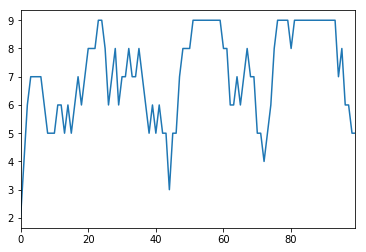

In [110]:
model_data_df.agentsOnBoard.plot()

###### Agent data

In [111]:
agent_data_df = boardModel.datacollector.get_agent_vars_dataframe()
agent_data_df.head()

birthday  exitday
Step AgentID                   
0    1               0      NaN
     2               0      NaN
1    1               0      NaN
     2               0      NaN
     3               0      NaN

In [112]:
agent_info_df = agent_data_df.query('Step==99')
agent_info_df.reset_index(level=0, drop=True, inplace=True)
agent_info_df.head()

birthday  exitday
AgentID                   
1               0      6.0
2               0      5.0
3               0      6.0
4               0      2.0
5               1      3.0

In [113]:
agent_info_df['duration'] = np.nan
exited_agents = agent_info_df.index[~agent_info_df.exitday.isnull()]
agent_info_df['duration'].loc[exited_agents] = agent_info_df['exitday'].loc[exited_agents] - \
                                               agent_info_df['birthday'].loc[exited_agents]
agent_info_df   

/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

birthday  exitday  duration
AgentID                             
1               0      6.0       6.0
2               0      5.0       5.0
3               0      6.0       6.0
4               0      2.0       2.0
5               1      3.0       2.0
6               1      9.0       8.0
7               2      4.0       2.0
8               2      7.0       5.0
9               3      8.0       5.0
10              4     10.0       6.0
11              5      9.0       4.0
12              6     11.0       5.0
13              8     11.0       3.0
14              9     14.0       5.0
15              9     12.0       3.0
16             10     12.0       2.0
17             10     13.0       3.0
18             11     15.0       4.0
19             11     14.0       3.0
20             12     14.0       2.0
21             13     17.0       4.0
22             13     24.0      11.0
23             14     25.0      11.0
24             14     17.0       3.0
25             15     25.0      10.0
26             15     27.0      12.0
27             16     18.0       2.0
28             17     26.0       9.0
29             18     20.0       2.0
30             18     28.0      10.0
...           ...      ...       ...
68             50     67.0      17.0
69             60     64.0       4.0
70             62     66.0       4.0
71             62     68.0       6.0
72             63     65.0       2.0
73             63     67.0       4.0
74             64     69.0       5.0
75             65     71.0       6.0
76             65     70.0       5.0
77             66     69.0       3.0
78             66     70.0       4.0
79             67     71.0       4.0
80             68     71.0       3.0
81             70     79.0       9.0
82             70     73.0       3.0
83             71     95.0      24.0
84             71     93.0      22.0
85             72     93.0      21.0
86             73     94.0      21.0
87             73     98.0      25.0
88             74     97.0      23.0
89             74     95.0      21.0
90             75     97.0      22.0
91             80     97.0      17.0
92             94     98.0       4.0
93             94      NaN       NaN
94             97      NaN       NaN
95             97      NaN       NaN
96             98      NaN       NaN
97             98      NaN       NaN

[97 rows x 3 columns]

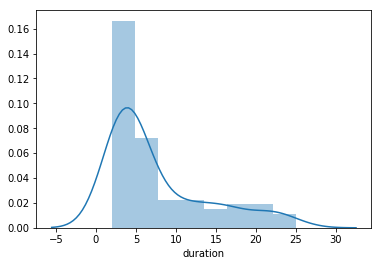

In [114]:
sns.distplot(agent_info_df.duration[~agent_info_df.duration.isnull()])

<hr>

Use visualization to test.

Seems like working.